In [2]:
#!pipenv install --skip-lock pmdarima
#!pipenv install --skip-lock matplotlib
!pipenv install --skip-lock nb-black

zsh:1: command not found: pipenv


In [3]:
# check pmdarima
from pmdarima.arima import auto_arima

In [4]:
import pmdarima
print(pmdarima.__version__)

2.0.2


### ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

In [5]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

/var/folders/84/pzq4qfg95hq5vhgd149f4qm80000gn/T/ipykernel_61420/519427871.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style="seaborn")


<IPython.core.display.Javascript object>

In [6]:
df = pd.read_csv("QQQ.csv")
df.head()

,timestamp,close
0,2015-12-01 14:30:00,108.37
1,2015-12-01 14:45:00,108.71
2,2015-12-01 15:00:00,108.52
3,2015-12-01 15:15:00,108.24
4,2015-12-01 15:30:00,108.46


<IPython.core.display.Javascript object>

In [7]:
df.head(5)

,timestamp,close
0,2015-12-01 14:30:00,108.37
1,2015-12-01 14:45:00,108.71
2,2015-12-01 15:00:00,108.52
3,2015-12-01 15:15:00,108.24
4,2015-12-01 15:30:00,108.46


<IPython.core.display.Javascript object>

In [8]:
df = df[["close"]].copy()

<IPython.core.display.Javascript object>

In [9]:
df.describe()

,close
count,48318.000000
mean,212.181890
std,87.574219
min,89.810000
25%,139.280000
50%,181.065000
75%,288.567500
max,404.910000


<IPython.core.display.Javascript object>

An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR term

- d is the number of differencing required to make the time series stationary

- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.



### Stationarity

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times. 

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model. 

#### ADF test

We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [10]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.0564622733255362
p-value: 0.7321184693513021


<IPython.core.display.Javascript object>

#### Autocorrelation Function (ACF)

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

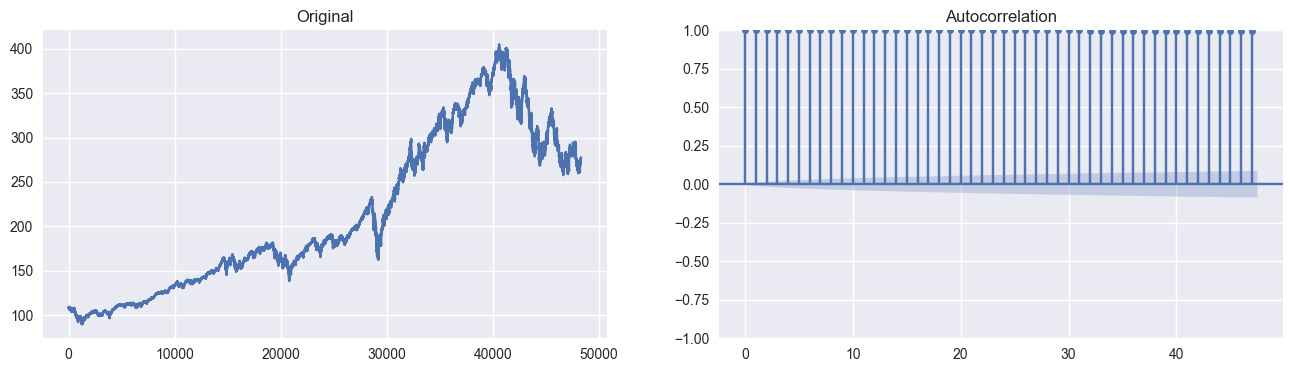

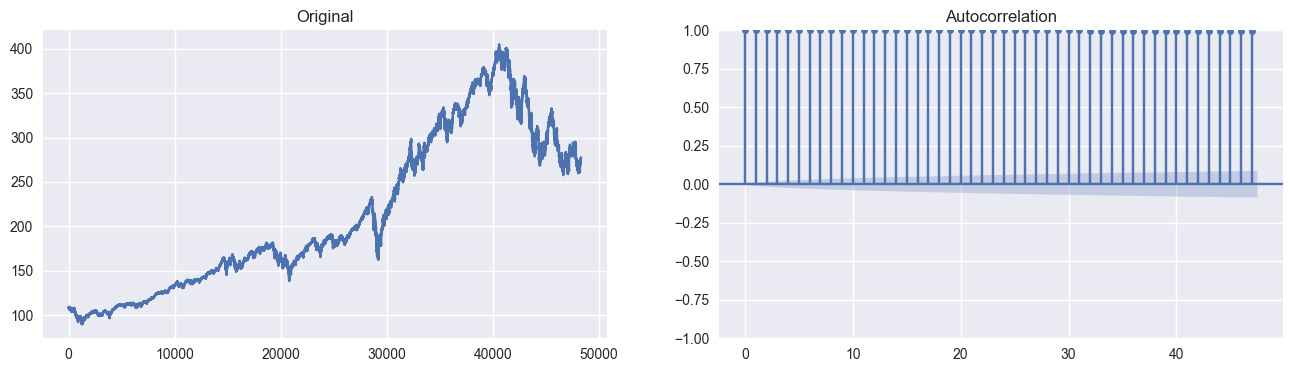

<IPython.core.display.Javascript object>

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.close, ax=ax2)

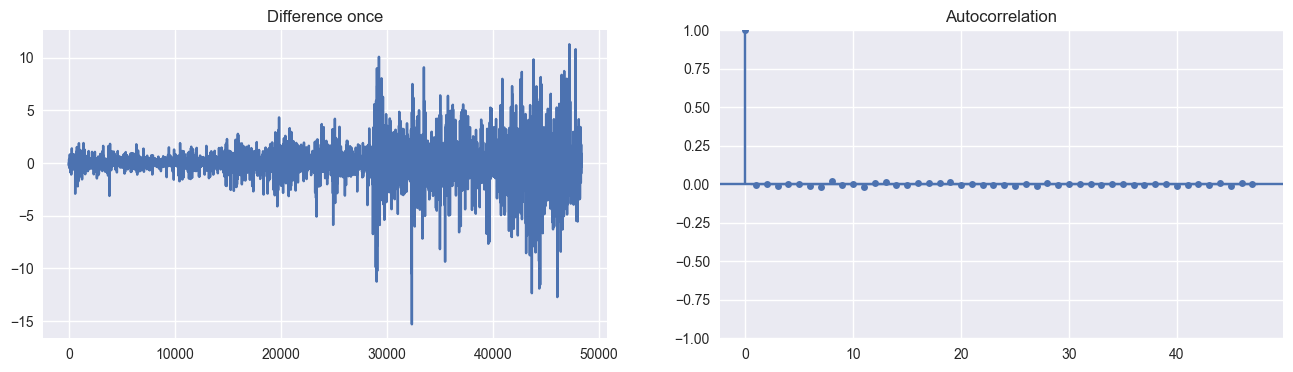

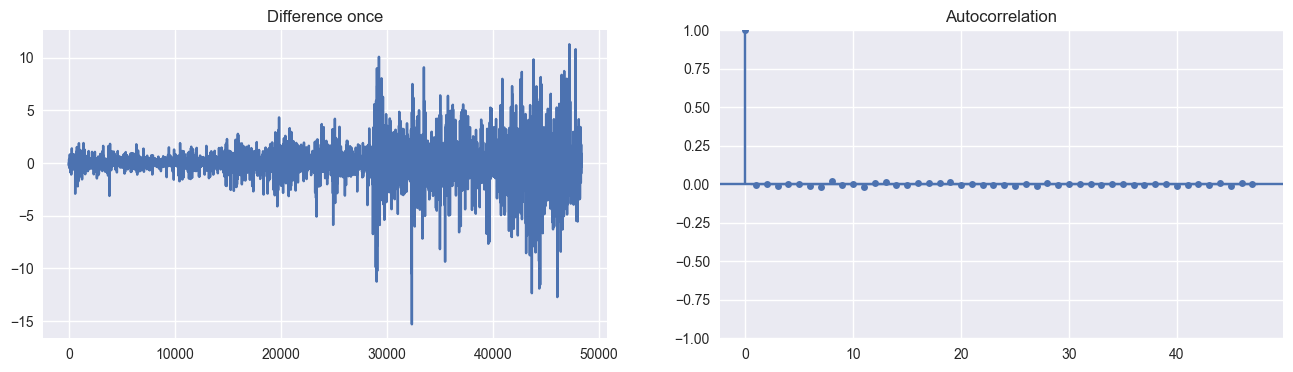

<IPython.core.display.Javascript object>

In [13]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)

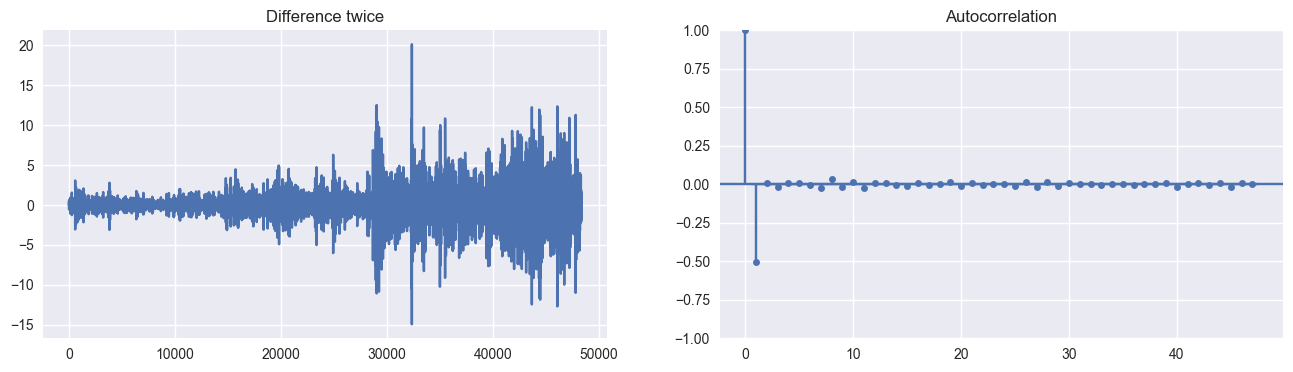

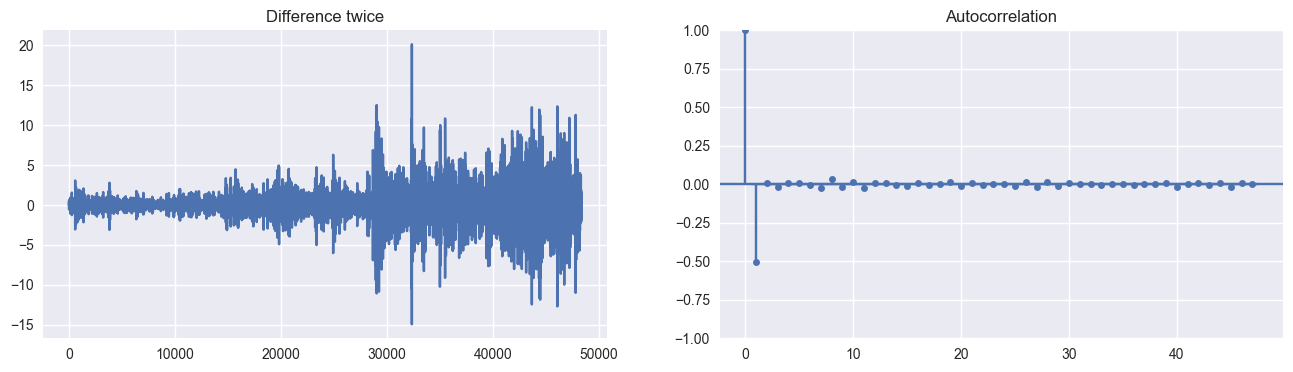

<IPython.core.display.Javascript object>

In [14]:
diff = df.close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2)

We can use the pmdarima package to get the number of differencing.

In [15]:
#!pipenv install --skip-lock pmdarima

from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

In [16]:
ndiffs(df.close, test="adf")

1

<IPython.core.display.Javascript object>

#### p

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags. 

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

/Users/shobair/Developer/githello-arima-freeze/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


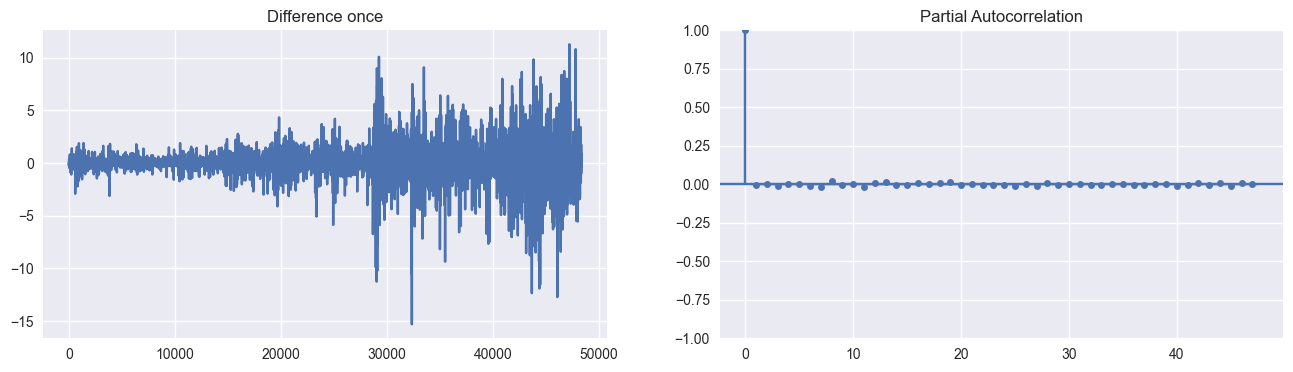

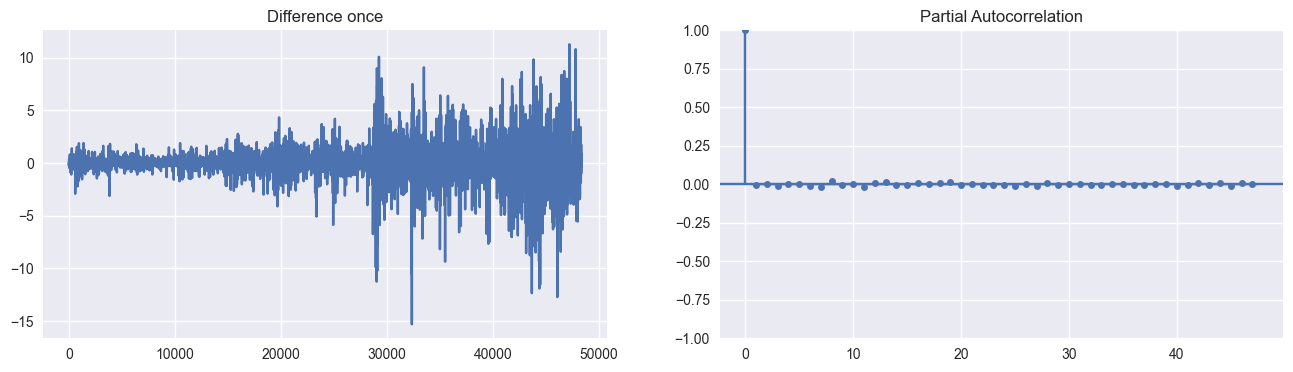

<IPython.core.display.Javascript object>

In [18]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)

We can observe that the PACF no lag is significant as it's above the significance line.

#### q

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.

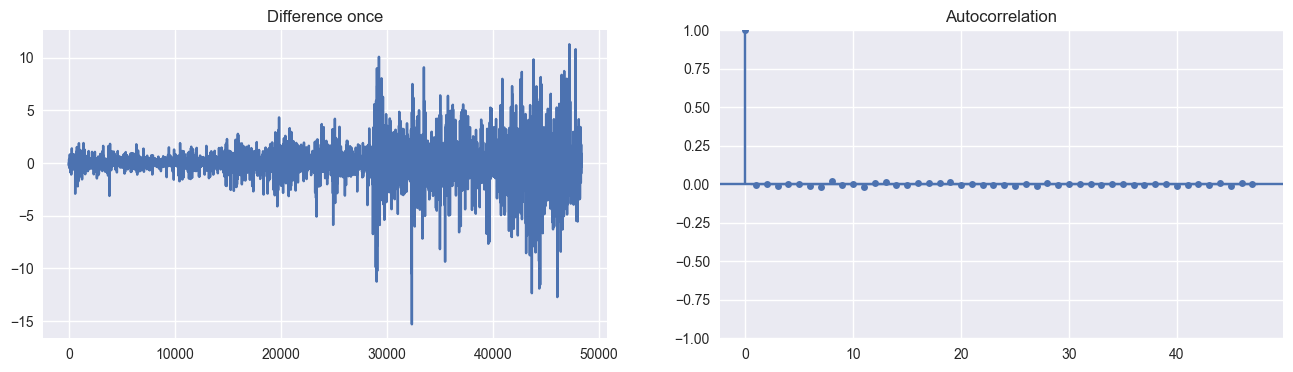

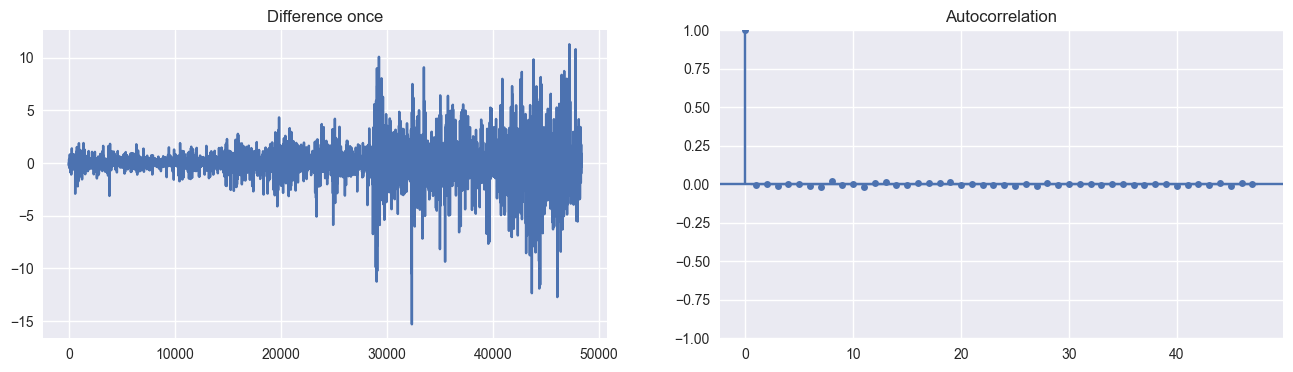

<IPython.core.display.Javascript object>

In [19]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)

#### Fitting the ARIMA model

In [20]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA Model
model = ARIMA(df.close, order=(1, 1, 2))
result = model.fit()


<IPython.core.display.Javascript object>

In [21]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                48318
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -47387.413
Date:                Thu, 09 Feb 2023   AIC                          94782.826
Time:                        19:19:53   BIC                          94817.968
Sample:                             0   HQIC                         94793.851
                              - 48318                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2136      1.157     -0.185      0.854      -2.482       2.055
ma.L1          0.2090      1.157      0.181      0.857      -2.059       2.477
ma.L2          0.0014      0.007      0.218      0.8

<IPython.core.display.Javascript object>

(array([2.91183530e-04, 8.05591030e-02, 6.69387424e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.67346856e-06]),
 array([-15.30260046,  -2.93534042,   9.43191963,  21.79917967,
         34.16643972,  46.53369977,  58.90095981,  71.26821986,
         83.63547991,  96.00273995, 108.37      ]),
 <BarContainer object of 10 artists>)

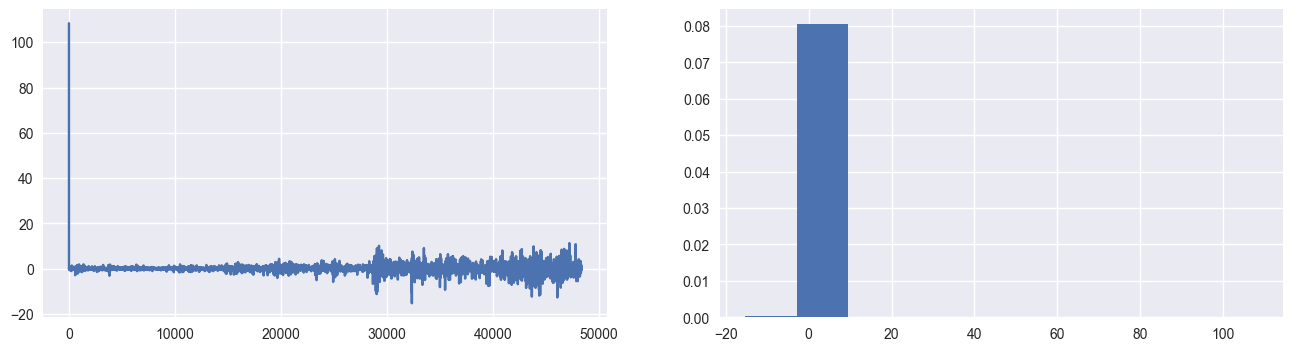

<IPython.core.display.Javascript object>

In [22]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)


In [23]:
# todo: plot actual vs predicted price using new pmdarima package version
# Actual vs Fitted
# result.plot_predict(
#     start=1,
#     end=60,
#     dynamic=False,
# )

<IPython.core.display.Javascript object>

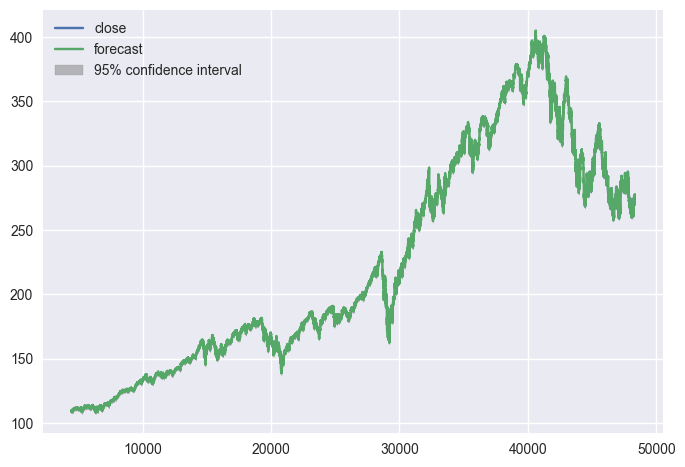

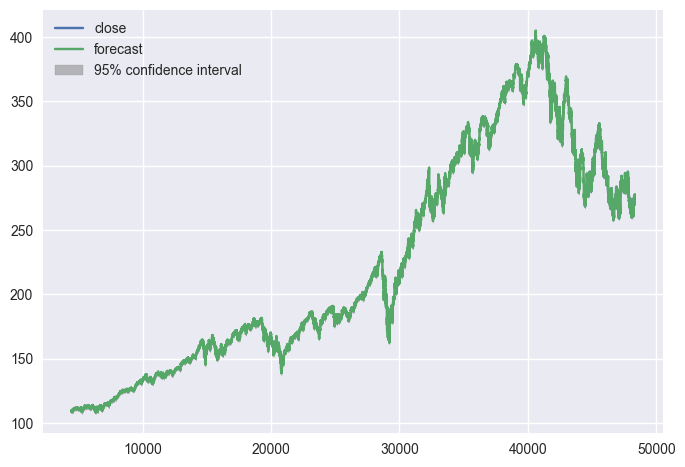

<IPython.core.display.Javascript object>

In [24]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
ax = df.loc["4441":].plot(ax=ax)
plot_predict(result, start=4441, dynamic=False, ax=ax, plot_insample=False)

### Train test split 

In [25]:
n = int(len(df) * 0.8)
train = df.close[:n]
test = df.close[n:]

<IPython.core.display.Javascript object>

In [26]:
print(len(train))
print(len(test))

38654
9664


<IPython.core.display.Javascript object>

In [27]:
step = 30

model = ARIMA(train, order=(6, 1, 3))
result = model.fit()

# Forecast
result = result.forecast(step)

/Users/shobair/Developer/githello-arima-freeze/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<IPython.core.display.Javascript object>

In [28]:
result

38654    363.164308
38655    363.162918
38656    363.150812
38657    363.149613
38658    363.161754
38659    363.165787
38660    363.155328
38661    363.149837
38662    363.159181
38663    363.166499
38664    363.159089
38665    363.150794
38666    363.156489
38667    363.165672
38668    363.162017
38669    363.152544
38670    363.154322
38671    363.163834
38672    363.163966
38673    363.154855
38674    363.153021
38675    363.161470
38676    363.164860
38677    363.157376
38678    363.152697
38679    363.159027
38680    363.164746
38681    363.159739
38682    363.153281
38683    363.156882
Name: predicted_mean, dtype: float64

<IPython.core.display.Javascript object>

In [29]:
# todo: update needed since the new pmdarima version realease or use older versions
# fc = pd.Series(fc, index=test[:step].index)
# lower = pd.Series(conf[:, 0], index=test[:step].index)
# upper = pd.Series(conf[:, 1], index=test[:step].index)

<IPython.core.display.Javascript object>

In [33]:
# todo: update needed since the new pmdarima version realease or use older versions
# plt.figure(figsize=(16, 8))
# plt.plot(test[:step], label="actual")
# # plt.plot(fc, label="forecast")
# plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
# plt.title("Forecast vs Actual")
# plt.legend(loc="upper left")

<IPython.core.display.Javascript object>

### Auto ARIMA

The pmdarima package provides an auto_arima method that uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [34]:
from pmdarima.arima import auto_arima

<IPython.core.display.Javascript object>

In [35]:
model = auto_arima(
    df.close,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=6,
    max_q=6,
    m=1,  # frequency of series
    d=None,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=94781.462, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=94778.729, Time=1.76 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=94779.685, Time=0.88 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=94779.684, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=94778.150, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 6.607 seconds


<IPython.core.display.Javascript object>